In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams['hatch.linewidth'] = 2

dataset = ["STK","TAO","HPC","GAS","EM","FC"]
dataset_small = ["STK","GAS","EM"]

alg_name = "MDUAL"

algo_color = {'NAIVE': 'grey',
              'SOP': '#4BACC6',
              'pMCSKY': '#1F497D',
              alg_name+'-Q': '#F79646',
              alg_name+'-D': '#9BBB59',
              alg_name: '#C0504D'}

algo_hatch = {'NAIVE': '||',
              'SOP': '++',
              'pMCSKY': 'xx',
              alg_name+'-Q': '--',
              alg_name+'-D': '//',
              alg_name: '\\\\\\'}

algo_line = {'NAIVE': '-',
              'SOP': '--',
              'pMCSKY': '-.',
              alg_name+'-Q': '--',
              alg_name+'-D': '--',
              alg_name: '-'}

algo_marker = {'NAIVE': '',
              'SOP': 's',
              'pMCSKY': '^',
              alg_name+'-Q': 'x',
              alg_name+'-D': 'x',
              alg_name: 'x'}


basic_linewidth = 3
algo_linewidth = {'NAIVE': basic_linewidth/2,
                  'SOP': basic_linewidth/2,
                  'pMCSKY': basic_linewidth/2,
                  alg_name+'-Q': basic_linewidth/2,
                  alg_name+'-D': basic_linewidth/2,
                  alg_name: basic_linewidth}

# Overall Bar Plot Parameters
barWidth = 0.75
FONTSIZE_XTICK=11
FONTSIZE_YTICK=11
FONTSIZE_XLABEL=13
FONTSIZE_YLABEL=13
intra_bar_space = 1.2
inter_bar_space = 2
figsize_overall=(10,2)
target_alg_overall = ['SOP','pMCSKY',alg_name+'-Q',alg_name+'-D',alg_name]

# Line Plot parameters
figsize_vp = (3,2)
target_alg_vp = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_vp=10
FONTSIZE_YTICK_vp=10
FONTSIZE_XLABEL_vp=14
FONTSIZE_YLABEL_vp=14

# stationarity Plot parameters
figsize_stationarity = (3,2)
target_alg_stationarity = ['SOP','pMCSKY',alg_name]
FONTSIZE_XTICK_stationarity=8
FONTSIZE_YTICK_stationarity=8
FONTSIZE_XLABEL_stationarity=12
FONTSIZE_YLABEL_stationarity=12


In [2]:
fileList = ['result_default_numQuery','result_varyingParams','result_varyingStatRatio','result_varingGrouping_STK_TAO_HPC','result_varingGrouping_GAS_EM_FC']

def preprocessing(path):
    headerf = open("Data/"+path+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
    w.write(header+"\n")

    f=open("Data/"+path+".txt",'r')
    i = -1
    for line in f.readlines():
        i += 1
        if (len(line.split())<9) or (i<1):
            continue
        line = line.replace("OURS",alg_name)
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")
    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")

    #averaging all trials
    dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method"]).mean()
    dataframe.reset_index(inplace=True)
    return dataframe   

def preprocessing_params(path):
    headerf = open("Data/"+path+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open(os.getcwd()+"/Metadata/"+path+"_separated.csv",'w')
    w.write(header+"\tparamKey"+"\n")

    f=open("Data/"+path+".txt",'r')
    i = -1
    for line in f.readlines():
        i += 1
        if (i<2):
            continue
        if 'Varying R' in line:
            param_key = "R"
            continue
        elif 'Varying K' in line:
            param_key = "K"
            continue
        elif 'Varying W' in line:
            param_key = "W"
            continue
        elif 'Varying S' in line:
            param_key = "S"
            continue
        line = line.replace("OURS",alg_name)
        line += "\t" + param_key
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")
    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/Metadata/"+path+"_separated.csv", sep="\t")
    dataframe = dataframe.groupby(["Dataset","Queryset","ChgQRatio","Method","paramKey"]).mean()
    dataframe.reset_index(inplace=True)
    return dataframe

In [3]:
def bargraph(df, dataset, metric, prefix, FONTSIZE_XLABEL, FONTSIZE_YLABEL, FONTSIZE_XTICK, FONTSIZE_YTICK, ytickList):
    dataset_ = dataset.copy()
    dataname = dataset_.pop()

    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values=metric)
    for dataname in dataset_:
        graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time")])

    graphdf = graphdf[target_alg_overall]
    graphdf = graphdf.reindex(index=dataset)
    fig = plt.figure(figsize=figsize_overall)
    ax = fig.add_subplot(1,1,1)
    xpositions = []
    for i, algname in enumerate(target_alg_overall):
        xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_overall) + inter_bar_space) + barWidth*intra_bar_space*i
        xpositions.append(xposition)
        ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
               linewidth=algo_linewidth[algname], zorder=2)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_yscale("log")
    ax.set_xlabel("Datasets", fontsize=FONTSIZE_XLABEL)
    if metric=="Time":
        ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)
    else:
        ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)

    ax.set_xlim([-barWidth,xposition[-1]+barWidth])
    ax.set_ylim([ytickList[0], ytickList[-1]])
    plt.yticks(ytickList)
    if metric!="Time":
        ax.set_yticklabels(list(map(str, ytickList)))
    xpositions=np.array(xpositions)
    xcenter = np.mean(xpositions,axis=0)
    plt.xticks(xcenter,dataset)
    for i in range(len(xcenter)-1):
        plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)
    # remove ticks
    ax.tick_params(axis ='both', which ='both', length = 0)
    ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK)
    ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
    # rotate ticks
    ax.tick_params(axis ='x', rotation = 0)
    if metric=="Time":
        plt.savefig("Figures/"+prefix+'_CpuTime.pdf', bbox_inches='tight', format='pdf')
    else:
        plt.savefig("Figures/"+prefix+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

In [4]:
def bargraph_Params(df, dataset, metric, FONTSIZE_XLABEL, FONTSIZE_YLABEL, FONTSIZE_XTICK, FONTSIZE_YTICK, ytickList):
    plt.rcParams['hatch.linewidth'] = 2
    for vp in ["R","K","W","S"]:
        dataset_ = dataset.copy()
        dataname = dataset_.pop()
        graphdf = df.loc[(df["Dataset"]==dataname) & (df['paramKey']==vp)].pivot(index="Dataset",columns="Method",values=metric)
        for dataname in dataset_:
            graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname) & (df['paramKey']==vp)].pivot(index="Dataset",columns="Method",values="Time")])
        graphdf = graphdf[target_alg_vp]
        graphdf = graphdf.reindex(index=dataset)
        fig = plt.figure(figsize=figsize_vp)
        ax = fig.add_subplot(1,1,1)
        xpositions = []
        for i, algname in enumerate(target_alg_vp):
            xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_vp) + inter_bar_space) + barWidth*intra_bar_space*i
            xpositions.append(xposition)
            ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
                   hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
                   linewidth=algo_linewidth[algname], zorder=2)
        ax.grid(b=True,which="major",axis='y',zorder=0)
        ax.set_yscale("log")
        ax.set_xlabel("Datasets", fontsize=FONTSIZE_XLABEL)
        if metric=="Time":
            ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)
        else:
            ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)

        ax.set_xlim([-barWidth,xposition[-1]+barWidth])
        ax.set_ylim([ytickList[0], ytickList[-1]])
        plt.yticks(ytickList)
        if metric!="Time":
            ax.set_yticklabels(list(map(str, ytickList)))
        xpositions=np.array(xpositions)
        xcenter = np.mean(xpositions,axis=0)
        plt.xticks(xcenter,dataset)
        for i in range(len(xcenter)-1):
            plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)
        # remove ticks
        ax.tick_params(axis ='both', which ='both', length = 0)
        ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK)
        ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
        # rotate ticks
        ax.tick_params(axis ='x', rotation = 0)
        if metric=="Time":
            plt.savefig("Figures/"+'VaryingParam_'+vp+'_CpuTime.pdf', bbox_inches='tight', format='pdf')
        else:
            plt.savefig("Figures/"+'VaryingParam_'+vp+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

In [5]:
df = preprocessing("result_default_numQuery_STK_1000_1")
print(df)


   Dataset   Queryset  ChgQRatio  Method       Time  AvgMem  PeakMem   #Out  \
0      STK     STK_Q1        0.2   MDUAL      0.576    4.00      9.0    7.0   
1      STK     STK_Q1        0.2     SOP     41.068    8.00     13.0    7.0   
2      STK     STK_Q1        0.2  pMCSKY     50.536    5.00     10.4    7.0   
3      STK    STK_Q10        0.2   MDUAL      3.636    3.92      9.0   15.4   
4      STK    STK_Q10        0.2     SOP   1412.816   83.46    117.4   15.4   
5      STK    STK_Q10        0.2  pMCSKY   1548.382   57.28    105.8   15.4   
6      STK   STK_Q100        0.2   MDUAL     25.854    4.00     10.6   93.2   
7      STK   STK_Q100        0.2     SOP  14782.172  179.82    213.6   93.2   
8      STK   STK_Q100        0.2  pMCSKY  14098.594  121.62    172.8   93.2   
9      STK  STK_Q1000        0.2   MDUAL    171.540    5.00     25.0  269.0   
10     STK  STK_Q1000        0.2     SOP  76605.500  681.00    713.0  269.0   
11     STK  STK_Q1000        0.2  pMCSKY  74777.800 

# Overall Performance
###### queryNumber=100, ChgQRatio>0, targetAlgorithm = SOP, pMCSKY, OURS

In [6]:
# df = preprocessing("result_default_numQuery")
# bargraph(df=df, dataset=dataset, metric="Time", prefix="Overall", \
#         FONTSIZE_XLABEL=FONTSIZE_XLABEL, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
#         FONTSIZE_TICK=FONTSIZE_TICK, ytickList=[1e1,1e3,1e5])
#
#
# bargraph(df=df, dataset=dataset, metric="PeakMem", prefix="Overall",\
#         FONTSIZE_XLABEL=FONTSIZE_XLABEL, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
#         FONTSIZE_TICK=FONTSIZE_TICK, ytickList=[1,32,1024])

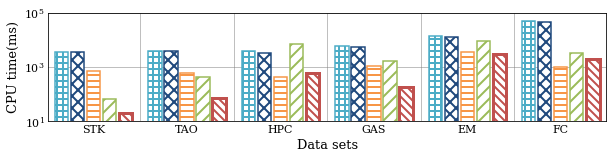

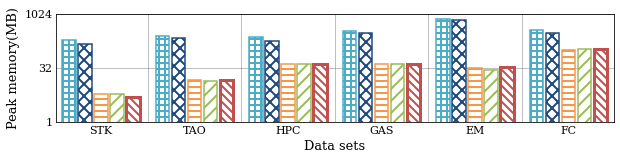

In [7]:
df1 = preprocessing("STK")
df2 = preprocessing("TAO")
df3 = preprocessing("GAS")
df4 = preprocessing("HPC")
df5 = preprocessing("EM")
df6 = preprocessing("FC")
df = pd.concat([df1,df2,df3,df4,df5,df6])
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="Time")])
graphdf = graphdf[target_alg_overall]

graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_overall)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([10,100000])
plt.yticks([10,1e3,1e5])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)


# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XTICK) # pad=15
ax.tick_params(axis ='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig("Figures/"+'Overall_CpuTime.pdf', bbox_inches='tight', format='pdf')


################
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_overall]

graphdf = graphdf.reindex(index=dataset)

fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_overall)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log",basey=2)
ax.set_xlabel("Data sets", fontsize=FONTSIZE_XLABEL)
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)
ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,1024])
plt.yticks([1,32,1024])
ax.set_yticklabels(['1','32','1024'])

xpositions=np.array(xpositions)
xcenter = np.mean(xpositions,axis=0)
plt.xticks(xcenter,dataset)
for i in range(len(xcenter)-1):
    plt.axvline(x=(xcenter[i]+xcenter[i+1])/2, color='grey', linewidth=0.5)

# remove ticks
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK)
ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)

plt.savefig("Figures/"+'Overall_PeakMem.pdf', bbox_inches='tight', format='pdf')

#### Overall Legend

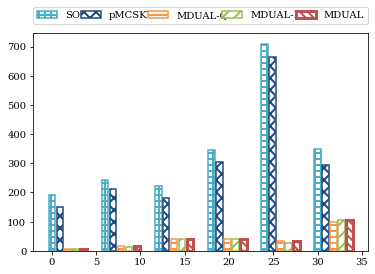

In [8]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_overall]

graphdf = graphdf.reindex(index=dataset)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_overall,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_overall), mode="expand", borderaxespad=0.)

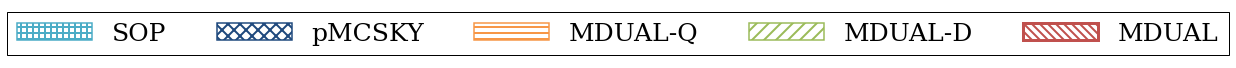

In [9]:
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(handles=bars,labels=target_alg_overall, loc='center', ncol=len(target_alg_overall), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =3,\
              prop={'size':25}
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'Overall_Legend.pdf', bbox_inches='tight', format='pdf')

# Changing the number of queries - CPU time, Peak memory
###### ChgQRatio>0, targetAlgorithm = ALL
## CPU time

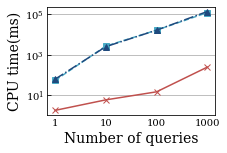

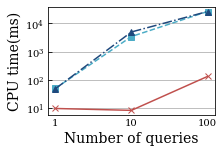

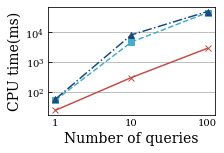

In [10]:
for dataname in dataset_small:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="Time")

    graphdf.reindex(index=dataset)
    fig = plt.figure(figsize=figsize_vp)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_vp):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log")
    ax.set_xlabel("Number of queries", fontsize=FONTSIZE_XLABEL_vp)
    ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_vp)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_vp)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_vp)
    ax.tick_params(axis='y', which ='minor', length = 0)
    ax.tick_params(axis='y', which ='major', direction='in')
    plt.savefig("Figures/"+'QueryNum_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

## Peak memory

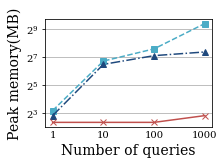

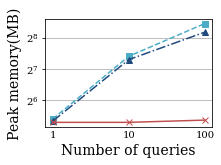

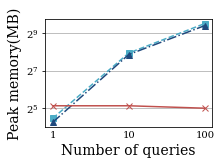

In [11]:
for dataname in dataset_small:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="PeakMem")

    graphdf.reindex(index=dataset)

    fig = plt.figure(figsize=figsize_vp)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_vp):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log",basey=2)
    ax.set_xlabel("Number of queries", fontsize=FONTSIZE_XLABEL_vp)
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_vp)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_vp)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_vp)
    plt.savefig("Figures/"+'QueryNum_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

# Changing the stationarity of queries - CPU time, Peak memory
###### numQuery=100, targetAlgorithm = ALL

In [12]:
# graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)
# graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)
#
# fig = plt.figure(figsize=figsize_vp)
# ax = fig.add_subplot(1,1,1)
# for i, algname in enumerate(target_alg_stationarity):
#     ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
#     ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
# ax.grid(b=True,which="major",axis='y',zorder=0)
# ax.set_xlabel("")
# ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
#
# ax.tick_params(axis='both', which ='both', length = 0)
# ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
# ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
#
# ax.tick_params(axis ='x', rotation = 0, pad=10)
# plt.savefig('Stationarity_CpuTime.pdf', bbox_inches='tight', format='pdf')
#
# graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)
# graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)
#
# fig = plt.figure(figsize=figsize_vp)
# ax = fig.add_subplot(1,1,1)
# for i, algname in enumerate(target_alg_stationarity):
#     ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
#     ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
# ax.grid(b=True,which="major",axis='y',zorder=0)
# ax.set_xlabel("")
# ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
#
# ax.tick_params(axis='both', which ='both', length = 0)
# ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
# ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
#
# ax.tick_params(axis ='x', rotation = 0, pad=10)
# plt.savefig('Stationarity_PeakMem.pdf', bbox_inches='tight', format='pdf')

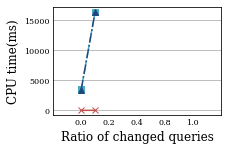

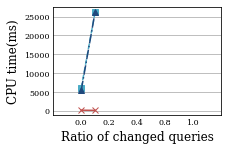

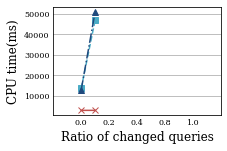

In [13]:
df1 = preprocessing("STK")
df2 = preprocessing("TAO")
df3 = preprocessing("GAS")
df4 = preprocessing("HPC")
df5 = preprocessing("EM")
df6 = preprocessing("FC")
df = pd.concat([df1,df2,df3,df4,df5,df6])


for dataname in dataset_small:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="Time")

    graphdf.index=df["ChgQRatio"].unique()
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(graphdf[algname].index.tolist(), graphdf[algname].tolist(), linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("Ratio of changed queries", fontsize=FONTSIZE_XLABEL_stationarity)
    ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.2,1])

    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_stationarity)
    plt.xticks([0.0,0.2,0.4,0.6,0.8])
    ax.set_xticklabels([0.0,0.2,0.4,0.8,1.0])
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig("Figures/"+'Stationarity_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

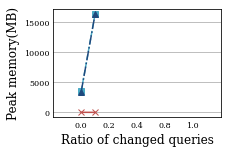

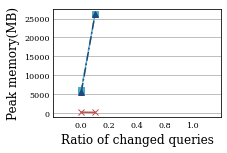

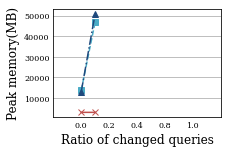

In [14]:

for dataname in dataset_small:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="Time")
    graphdf.index=df["ChgQRatio"].unique()
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("Ratio of changed queries", fontsize=FONTSIZE_XLABEL_stationarity)
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.2,1])

    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XTICK_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_YTICK_stationarity)

    ax.tick_params(axis ='x', rotation = 0)
    plt.xticks([0.0,0.2,0.4,0.6,0.8])
    ax.set_xticklabels([0.0,0.2,0.4,0.8,1.0])
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig("Figures/"+'Stationarity_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

## Stationary Legend

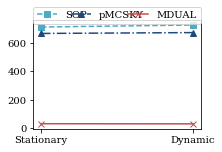

In [15]:
graphdf_nochange = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']==0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf_change = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf = pd.concat([graphdf_nochange,graphdf_change])
graphdf.index=["Stationary",'Dynamic']
graphdf = graphdf[target_alg_stationarity]
fig = plt.figure(figsize=figsize_stationarity)
ax = fig.add_subplot(1,1,1)
plots = []
for i, algname in enumerate(target_alg_stationarity):
    plot = ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    plots += plot
# legend = ax.legend(handles=plots,labels=target_alg_stationarity)

legend = ax.legend(handles=plots,labels=target_alg_stationarity,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_stationarity), mode="expand", borderaxespad=0.)

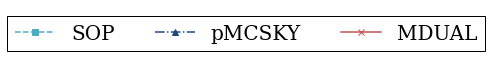

In [16]:
figsize = (7, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

ax_leg.legend(handles=plots,labels=target_alg_stationarity, loc='center', ncol=len(target_alg_stationarity), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =2,\
               prop={'size':20})
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'Stationarity_Legend.pdf', bbox_inches='tight', format='pdf')



# Varying Parameters

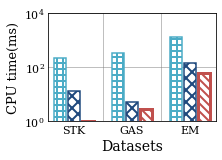

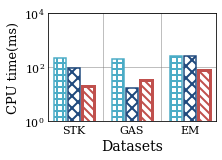

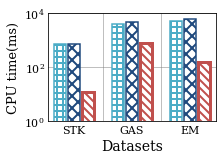

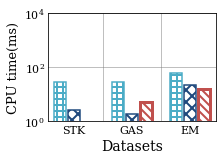

In [17]:
df = preprocessing_params('result_varyingParams')
bargraph_Params(df=df, dataset=dataset_small, metric="Time", \
                FONTSIZE_XLABEL=FONTSIZE_XLABEL_vp, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
                FONTSIZE_XTICK=FONTSIZE_XTICK, FONTSIZE_YTICK=FONTSIZE_YTICK, ytickList=[1,1e2,1e4])

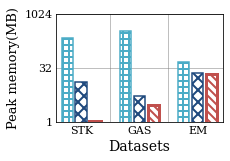

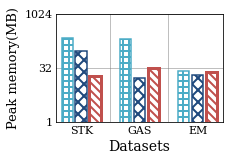

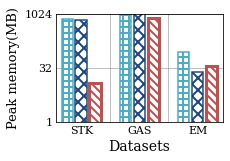

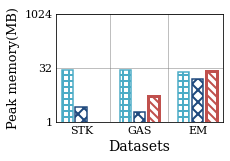

In [18]:
bargraph_Params(df=df, dataset=dataset_small, metric="PeakMem", \
                FONTSIZE_XLABEL=FONTSIZE_XLABEL_vp, FONTSIZE_YLABEL=FONTSIZE_YLABEL,\
                FONTSIZE_XTICK=FONTSIZE_XTICK, FONTSIZE_YTICK=FONTSIZE_YTICK, ytickList=[1,32,1024])

## Varying Param Legend

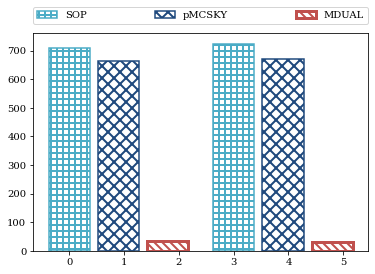

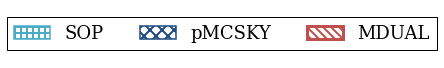

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_vp):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_vp,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_overall), mode="expand", borderaxespad=0.)

figsize = (7, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

ax_leg.legend(handles=bars,labels=target_alg_vp, loc='center', ncol=len(target_alg_stationarity), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =2,\
               prop={'size':18})
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("Figures/"+'VaryingParam_Legend.pdf', bbox_inches='tight', format='pdf')